In [2]:
import sys
sys.path.append('/cmlscratch/nehamk/Segment-Everything-Everywhere-All-At-Once')

from seem_module.modeling.BaseModel import BaseModel
from seem_module.modeling import build_model
from seem_module.utils.arguments import load_opt_from_config_files
from seem_module.utils.constants import COCO_PANOPTIC_CLASSES
from seem_module.utils.distributed import init_distributed
from seem_module.utils.visualizer import Visualizer


sys.path.append('/cmlscratch/nehamk/RelateAnything')

from relate_anything.segment_anything import build_sam, SamPredictor, SamAutomaticMaskGenerator
from relate_anything.utils import iou, sort_and_deduplicate, relation_classes, MLP, show_anns, show_mask
from relate_anything.ram_train_eval import RamModel,RamPredictor

import os
import torch 
from detectron2.utils.colormap import random_color
from detectron2.data import MetadataCatalog
from detectron2.structures import BitMasks
from PIL import Image
from torchvision import transforms 
import numpy as np 
import matplotlib.pyplot as plt 

from mmengine.config import Config


Deformable Transformer Encoder is not available.


In [3]:
conf_files = '/cmlscratch/nehamk/Segment-Everything-Everywhere-All-At-Once/seem_module/configs/seem/focall_unicl_lang_demo.yaml'
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

# META DATA
cur_model = 'None'
if 'focalt' in conf_files:
    pretrained_pth = os.path.join("seem_focalt_v0.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focalt_v0.pt"))
    cur_model = 'Focal-T'
elif 'focal' in conf_files:
    pretrained_pth = os.path.join("seem_focall_v0.pt")
    if not os.path.exists(pretrained_pth):
        os.system("wget {}".format("https://huggingface.co/xdecoder/SEEM/resolve/main/seem_focall_v0.pt"))
    cur_model = 'Focal-L'

'''
build model
'''
model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    thing_colors = [random_color(rgb=True, maximum=255).astype(np.int32).tolist() for _ in range(len(COCO_PANOPTIC_CLASSES))]
    thing_dataset_id_to_contiguous_id = {x:x for x in range(len(COCO_PANOPTIC_CLASSES))}
    
    MetadataCatalog.get("demo").set(
        thing_colors=thing_colors,
        thing_classes=COCO_PANOPTIC_CLASSES,
        thing_dataset_id_to_contiguous_id=thing_dataset_id_to_contiguous_id,
    )
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(COCO_PANOPTIC_CLASSES + ["background"], is_eval=False)
    metadata = MetadataCatalog.get('demo')
    model.model.metadata = metadata
    model.model.sem_seg_head.num_classes = len(COCO_PANOPTIC_CLASSES)

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([134])


In [4]:
transform = transforms.Compose([
                transforms.Resize((512, 512), interpolation=Image.BICUBIC),
                transforms.PILToTensor()
            ])

image_ori = Image.open('person_with_coffee.jpeg').convert("RGB")
# image_ori = Image.open('/fs/cml-datasets/coco/images/train2017/000000000009.jpg').convert("RGB")

width = image_ori.size[0]
height = image_ori.size[1]
image = transform(image_ori)
image_ori = np.asarray(image_ori)

batch_inputs = [{'image': image, 'height': height, 'width': width}]

with torch.no_grad():
    outputs = model.forward(batch_inputs)

In [5]:
visual = Visualizer(image_ori, metadata=metadata)

inst_seg = outputs[-1]['instances']
inst_seg.pred_masks = inst_seg.pred_masks.cpu()
inst_seg.pred_boxes = BitMasks(inst_seg.pred_masks > 0).get_bounding_boxes()
demo = visual.draw_instance_predictions(inst_seg) # rgb Image

demo.save('inst.png')


In [31]:
sel_inst_seg = inst_seg[(inst_seg.scores > 0.5).cpu()]
masks = BitMasks(sel_inst_seg.pred_masks > 0)
bboxes = masks.get_bounding_boxes()

sel_inst_seg.pred_classes

tensor([125, 123,   0,  13, 116,  73], device='cuda:0')

In [32]:
[COCO_PANOPTIC_CLASSES[i] for i in sel_inst_seg.pred_classes]

['grass-merged', 'pavement-merged', 'person', 'bench', 'tree-merged', 'book']

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 512
hidden_size = 256
num_classes = 56


sam = build_sam(checkpoint="/cmlscratch/nehamk/RelateAnything/relate_anything/sam_vit_h_4b8939.pth").to(device)
sam_predictor = SamPredictor(sam)
sam_mask_generator = SamAutomaticMaskGenerator(sam)

# load ram model
model_path = "/cmlscratch/nehamk/RelateAnything/relate_anything/epoch_12.pth"
config = dict(
    model=dict(
        pretrained_model_name_or_path='bert-base-uncased',
        load_pretrained_weights=False,
        num_transformer_layer=2,
        input_feature_size=256,
        output_feature_size=768,
        cls_feature_size=512,
        num_relation_classes=56,
        pred_type='attention',
        loss_type='multi_label_ce',
    ),
    load_from=model_path,
)
config = Config(config)

class Predictor(RamPredictor):
    def __init__(self,config):
        self.config = config
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self._build_model()

    def _build_model(self):
        self.model = RamModel(**self.config.model).to(self.device)
        if self.config.load_from is not None:
            self.model.load_state_dict(torch.load(self.config.load_from, map_location=self.device), strict=False)
        self.model.train()

ram_predictor = Predictor(config)

Use Multi Label Cross Entropy Loss.


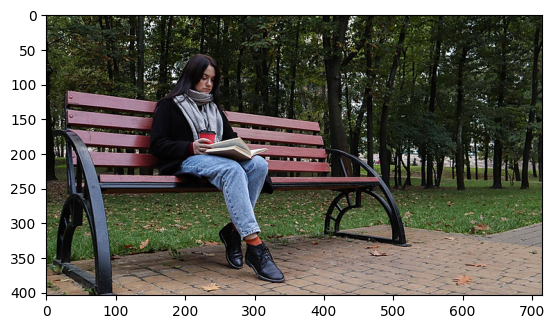

In [112]:
plt.imshow(image_ori)

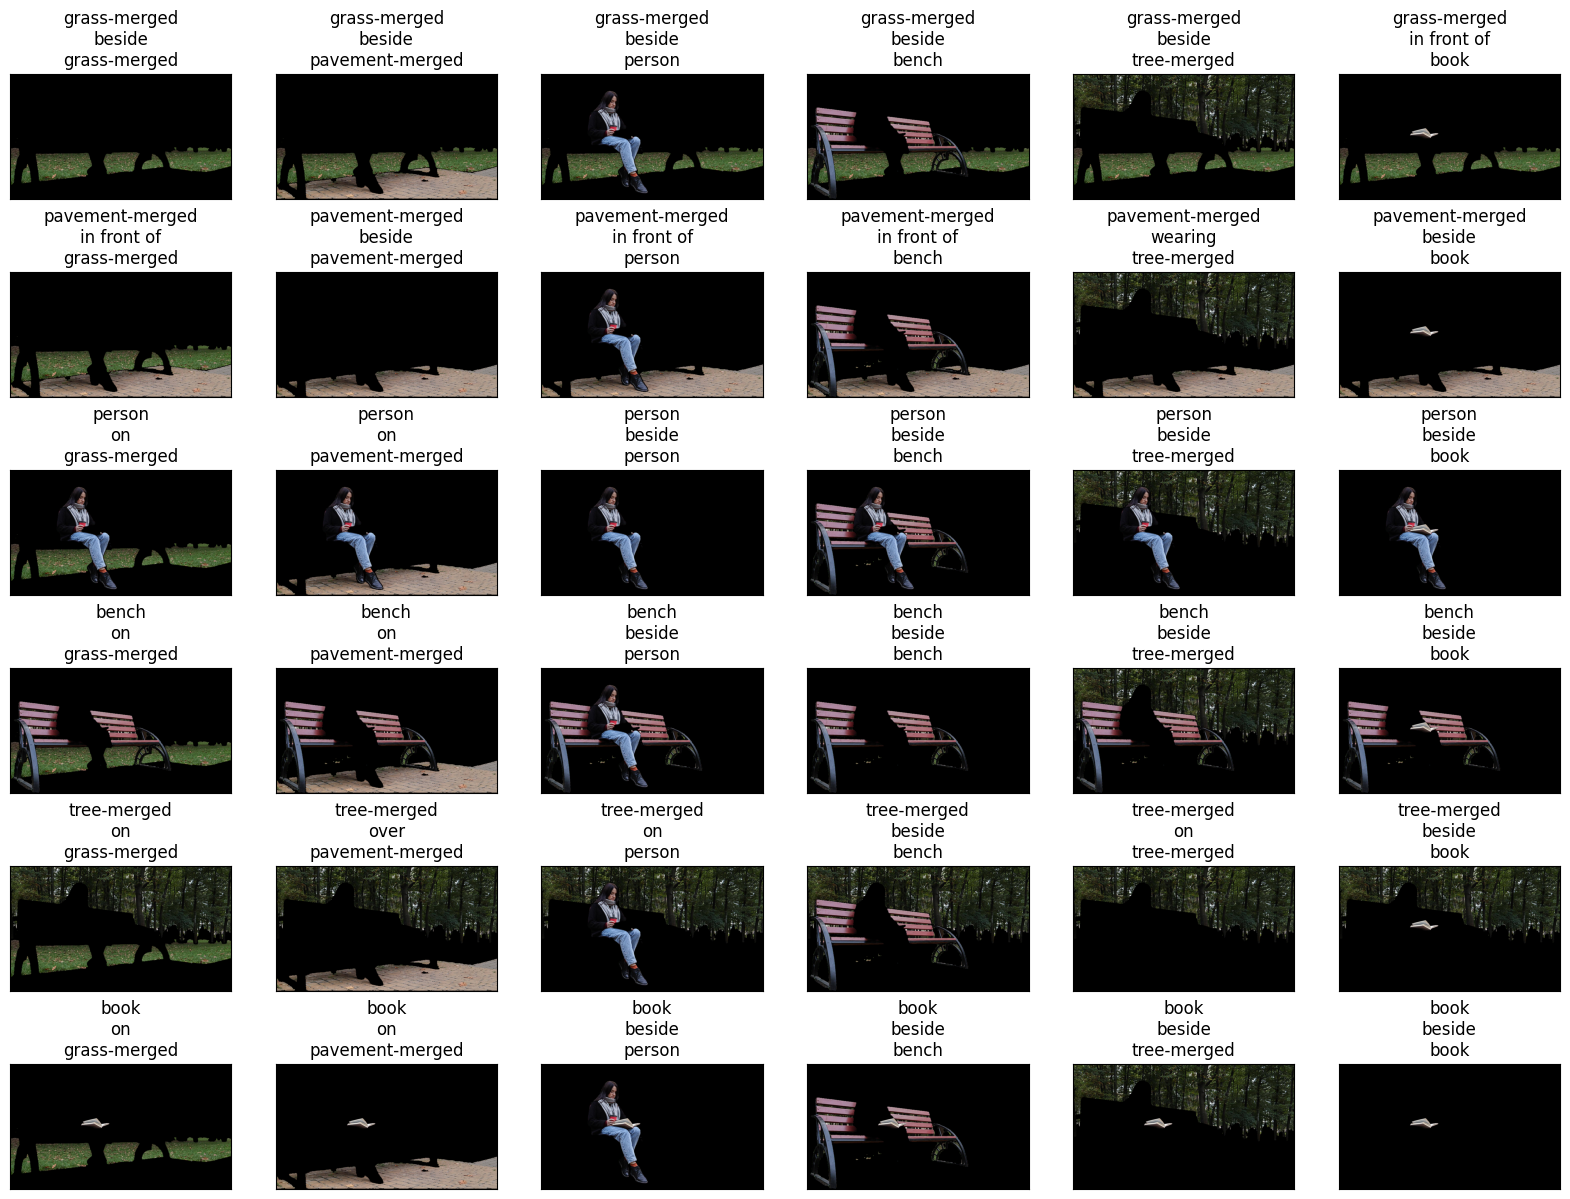

In [115]:
sam_predictor.set_image(image_ori)

fig, ax = plt.subplots(bboxes.tensor.shape[0], bboxes.tensor.shape[0], figsize = (20, 15))

for b1 in range(bboxes.tensor.shape[0]):
    for b2 in range(bboxes.tensor.shape[0]):
        mask1, score1, logit1, feat1 = sam_predictor.predict(
            # mask_input = masks[2].tensor,
            box = bboxes[b1].tensor.cpu().numpy(),
            multimask_output = False
        )
    
        mask2, score2, logit2, feat2 = sam_predictor.predict(
            # mask_input = masks[2].tensor,
            box = bboxes[b2].tensor.cpu().numpy(),
            multimask_output = False
        )

        feat = torch.cat((feat1, feat2), dim=1)
        matrix_output, rel_triplets = ram_predictor.predict(feat)
        
        subject_output = matrix_output.permute([0,2,3,1])[:,0,1:]
        
        output = subject_output[:,0]
        topk_indices = torch.argsort(-output).flatten()
        relation = relation_classes[topk_indices[:1][0]]

        ax[b1][b2].imshow(image_ori * np.maximum(mask1, mask2).transpose(1,2,0))
        ax[b1][b2].set_title(f'{COCO_PANOPTIC_CLASSES[sel_inst_seg.pred_classes[b1]]}\n{relation}\n{COCO_PANOPTIC_CLASSES[sel_inst_seg.pred_classes[b2]]}')
        ax[b1][b2].set_xticks([])
        ax[b1][b2].set_yticks([])